In [76]:
import pandas as pd 
import numpy as np 

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [13]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df_filter = df[['ram', 'storage', 'screen', 'final_price']]
df_filter


,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


<Axes: xlabel='final_price', ylabel='Count'>

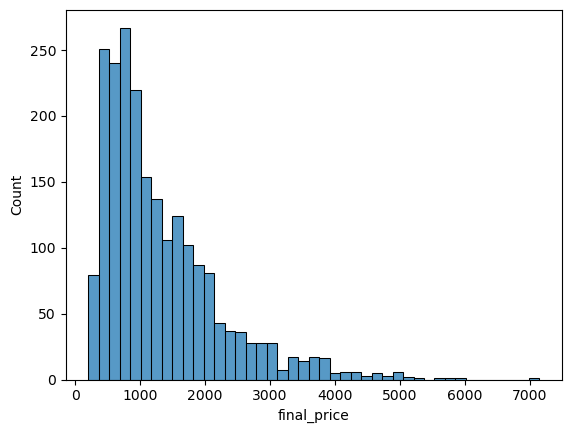

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.histplot(df_filter.final_price)

Q1. Missing Value

In [19]:
df_filter.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

Q2. Median

In [20]:
df_filter.ram.median()

16.0

Prepare and split

In [21]:
n = len(df_filter)
# Calculate record counts
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
# Dividing record amount for TVT

In [23]:
idx = np.arange(n)
# Get the index number of the record
np.random.seed(42)
# Use a random seed to make sure the random number is reproducible
np.random.shuffle(idx)
# Randomize idx


df_train = df_filter.iloc[idx[:n_train]]
df_val = df_filter.iloc[idx[n_train:n_train+n_val]]
df_test = df_filter.iloc[idx[n_train+n_val:]]
# Same as previous code, but taken from randomized index array

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
# Create new index, then deleting the previous index

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)
# Create new array for target value of each record as logaritmic distribution

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']
# Delete the target column from dataframe

Q3. Filling NAs

In [24]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [27]:
X_train_0 = df_train.fillna(0).values
w0, w = train_linear_regression(X_train_0, y_train)
y_pred_0 = w0 + X_train_0.dot(w)

In [28]:
X_train_mean = df_train.fillna(df.screen.mean()).values
w0, w = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0 + X_train_mean.dot(w)

In [29]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [38]:
rmse_0 = rmse(y_train, y_pred_0)
rmse_mean = rmse(y_train, y_pred_mean)
round(rmse_0, 2), round(rmse_mean, 2)

(0.45, 0.45)

Q4. Regularization

In [39]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

In [40]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [45]:
def prepare_X(df):
    df_num = df.fillna(0)
    X = df_num.values
    return X

In [47]:
for r in r_list:
    w_0_zeros_reg, w_zeros_reg = train_linear_regression_reg(df_train, y_train, r)
    y_pred_zeros_reg = w_0_zeros_reg + df_val.dot(w_zeros_reg)
    print("r: ", r, ", rmse: ", rmse(y_val, y_pred_zeros_reg))

r:  0 , rmse:  0.4288635315474421
r:  0.01 , rmse:  0.4288516360534068
r:  0.1 , rmse:  0.4287756009707626
r:  1 , rmse:  0.43059329897434373
r:  5 , rmse:  0.46320952575806407
r:  10 , rmse:  0.5075657769236902
r:  100 , rmse:  0.6735026061725831


Q5. RMSE Spread

In [101]:
def prepare_dataset(data, seed):
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)

    res_shuffled = data.iloc[idx]

    res_train = res_shuffled.iloc[:n_train].copy()
    res_val = res_shuffled.iloc[n_train:n_train+n_val].copy()
    res_test = res_shuffled.iloc[n_train+n_val:].copy()

    y_res_train_orig = res_train.final_price.values
    y_res_val_orig = res_val.final_price.values
    y_res_test_orig = res_test.final_price.values

    # y_res_train = np.log1p(res_train.final_price.values)
    # y_res_val = np.log1p(res_val.final_price.values)
    # y_res_test = np.log1p(res_test.final_price.values)

    del res_train['final_price']
    del res_val['final_price']
    del res_test['final_price']

    return res_train, res_val, res_test, y_res_train_orig, y_res_val_orig, y_res_test_orig

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [102]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_list = np.array([])

for s in seeds:
    df_q5 = df.copy().fillna(0)
    res_q5_train, res_q5_val, res_q5_test, y_res_q5_train, y_res_q5_val, y_res_q5_test = prepare_dataset(df_q5, s)
    w_0_q5, w_q5 = train_linear_regression(res_q5_train.values, y_res_q5_train)
    y_pred_q5 = w_0_q5 + res_q5_val.values.dot(w_q5)
    print(rmse(y_res_q5_val, y_pred_q5))
    rmse_list = np.append(rmse_list, rmse(y_res_q5_val, y_pred_q5))

TypeError: can't multiply sequence by non-int of type 'str'

In [85]:
round(rmse_list.std(), 3)

nan

Q6. RMSE on Test

In [103]:
df_dummy = df.copy().fillna(0)
res_q6_train, res_q6_val, res_q6_test, y_res_q6_train, y_res_q6_val, y_res_q6_test = prepare_dataset(df_dummy, 9)

df_q6_train = pd.concat([res_q6_train, res_q6_val], axis=0, ignore_index=True)
y_df_q6_train = np.concatenate([y_res_q6_train, y_res_q6_val])

w_0_q6, w_q6 = train_linear_regression_reg(df_q6_train.values, y_df_q6_train, 0.001)
y_pred_q6 = w_0_q6 + res_q6_test.values.dot(w_q6)
print(round(rmse(y_res_q6_test, y_pred_q6), 2))

TypeError: can't multiply sequence by non-int of type 'str'